## ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display


In [2]:
# Load the labeled data
good_examples = pd.read_csv('./data/good_period_2024_01_03.csv')
good_examples

bad_examples = pd.read_csv('./data/bad_period_2024_01_06.csv')
bad_examples

all_good_segments = []
all_bad_segments = []

In [3]:
# Apply the indicator function to create a new column
good_examples['indicator'] = good_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_good = good_examples.index[good_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_good.append(len(good_examples))


# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_good)-1):
    good_segment = good_examples.iloc[start_indices_good[i]:start_indices_good[i + 1]]
    all_good_segments.append(good_segment)

# Downsample 
for i in range(len(all_good_segments)):
    all_good_segments[i] = all_good_segments[i].iloc[::5]

print("Total Good Cutting Data:", len(all_good_segments))
print("Shape of Segment 1:", all_good_segments[0].shape)
print("Shape of Torque Data:", all_good_segments[0]['Torque'].shape)


Total Good Cutting Data: 4552
Shape of Segment 1: (334, 11)
Shape of Torque Data: (334,)


In [4]:
# Apply the indicator function to create a new column
bad_examples['indicator'] = bad_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_bad = bad_examples.index[bad_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_bad.append(len(bad_examples))

# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_bad)-1):
    segment = bad_examples.iloc[start_indices_bad[i]:start_indices_bad[i + 1]]
    all_bad_segments.append(segment)

# Downsample 
for i in range(len(all_bad_segments)):
    all_bad_segments[i] = all_bad_segments[i].iloc[::5]

print("Total Bad Cutting Data:", len(all_bad_segments))
print("Shape of Segment 1:", all_bad_segments[0].shape)
print("Shape of Torque Data:", all_bad_segments[0]['Torque'].shape)


Total Bad Cutting Data: 1937
Shape of Segment 1: (334, 11)
Shape of Torque Data: (334,)


## Convert Time-Series into Spectogram Features

### MFT Spectogram Features

/tmp/ipykernel_204104/2978787634.py:17: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)


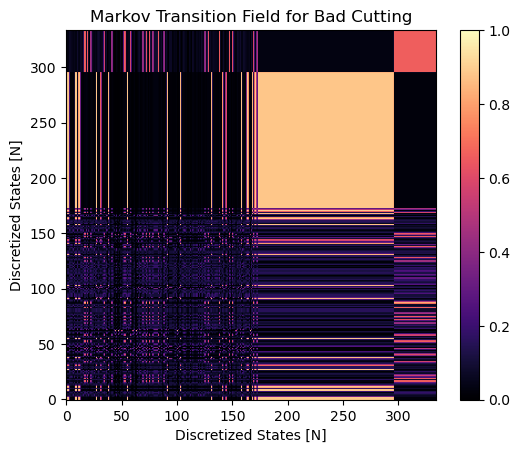

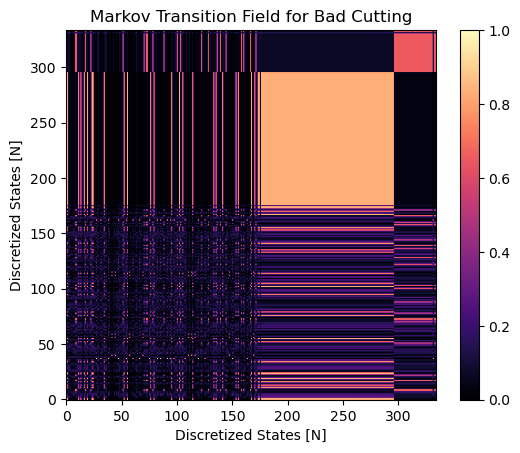

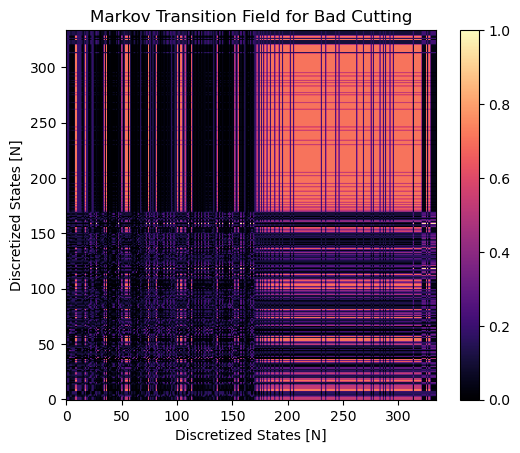

In [47]:
import random

good_mft_features = []
bad_mft_features = []

def compute_mft_spectrogram(time_series, n_bins=15):
    # Discretize the time series into n_bins
    bins = np.linspace(np.min(time_series), np.max(time_series), n_bins)
    digitized = np.digitize(time_series, bins) - 1  # Bins are 0-indexed

    # Compute the transition matrix
    transition_matrix = np.zeros((n_bins, n_bins))
    for (i, j) in zip(digitized[:-1], digitized[1:]):
        transition_matrix[i, j] += 1

    # Normalize the transition matrix
    transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

    # Map the time series data to the transition matrix to create the MTF
    mtf = transition_matrix[digitized][:, digitized]
    return mtf

    fig = plt.figure()
    plt.imshow(mtf, cmap='magma', origin='lower')
    plt.title(f'Markov Transition Field for Bad Cutting')
    plt.xlabel('Discretized States [N]')
    plt.ylabel('Discretized States [N]')
    plt.colorbar()
    plt.show()
    
    fig.savefig(f'/home/admin-anedunga/Desktop/InDas_Template/figures and graphs/bad_cutting_mft{random.randint(1, 9)}.png', dpi=fig.dpi)

    return mtf
    

# Plot the spectrogram of the first segment
# Sample number
MAX_SAMPLES_GOOD = 4552
# Sample number
MAX_SAMPLES_BAD = 1937
#MAX_SAMPLES_GOOD, MAX_SAMPLES_BAD = 3, 3

for i in range(MAX_SAMPLES_GOOD):
    good_cutting_mft = np.asarray(all_good_segments[i]['Torque'])
    good_mft = compute_mft_spectrogram(good_cutting_mft)
    good_mft_features.append(good_mft)
    
for i in range(MAX_SAMPLES_BAD):
    bad_cutting_mft = np.asarray(all_bad_segments[i]['Torque'])
    bad_mft = compute_mft_spectrogram(bad_cutting_mft)
    bad_mft_features.append(bad_mft)


print(good_mft.shape)


## Undersample Classes to Balance Them

### Markov Transition Field Features

In [6]:
SAMPLES_FOR_TRAINING = 1800
balanced_good_mft_features = np.array(good_mft_features[:SAMPLES_FOR_TRAINING])
balanced_bad_mft_features = np.array(bad_mft_features[:SAMPLES_FOR_TRAINING])

validation_good_mft_features = np.array(good_mft_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_GOOD])
validation_bad_mft_features = np.array(bad_mft_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_BAD])

validation_good_mft_labels = np.ones(validation_good_mft_features.shape[0])
validation_bad_mft_labels = np.zeros(validation_bad_mft_features.shape[0])

validation_mft_features = np.concatenate((validation_good_mft_features, validation_bad_mft_features), axis=0)
validation_mft_labels = np.concatenate((validation_good_mft_labels, validation_bad_mft_labels), axis=0)
print("mft Features Val Shape:", validation_mft_features.shape)
print("Balanced_Good", balanced_good_mft_features.shape)
print("Balanced_Bad", balanced_bad_mft_features.shape)

mft Features Val Shape: (0,)
Balanced_Good (3, 334, 334)
Balanced_Bad (0,)


## Dataloader

### MFT

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Create labels for the features
good_labels = [1] * len(balanced_good_mft_features)  # Label 1 for good torque
bad_labels = [0] * len(balanced_bad_mft_features)    # Label 0 for bad torque

# Combine features and labels
features = np.array(balanced_good_mft_features + balanced_bad_mft_features)
labels = np.array(good_labels + bad_labels)

# Custom Dataset class
class MelSpectrogramDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create dataset and dataloaders
dataset = MelSpectrogramDataset(features, labels)
train_size = int(0.4 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_dataset = MelSpectrogramDataset(validation_mft_features, validation_mft_labels)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


ValueError: operands could not be broadcast together with shapes (3,334,334) (0,) 

## Training ResNet 18

In [ ]:

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Modify ResNet-18
class ResNet18MelSpectrogram(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18MelSpectrogram, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer before the fully connected layer
            nn.Linear(self.resnet.fc.in_features, 2)  # 2 classes: good and bad
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

# Instantiate model, loss function, and optimizer
model = ResNet18MelSpectrogram(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)


# Training loop with loss tracking
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loss = []  # List to store training loss for each epoch
val_loss = []  # List to store validation loss for each epoch (if available)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / train_size
    train_loss.append(epoch_loss)  # Append training loss to the list

    # Add validation loss calculation here (if you have validation data)
    if val_loader:  # Check if validation loader exists
        model.eval()
        with torch.no_grad():
            val_epoch_loss = 0.0
            for inputs, labels in val_loader:
                inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item() * inputs.size(0)
            val_epoch_loss /= test_size  # Calculate average validation loss
            val_loss.append(val_epoch_loss)  # Append validation loss to the list

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')


# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Plotting training and validation loss (if available)
if val_loss:  # Check if validation loss data exists
    plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("Validation data not found. Training loss plotted only.")
    plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

UsageError: Line magic function `%` not found.


### Validation

In [ ]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Correct Preditions/Total", correct, "/", total)
print(f'Validation Accuracy: {accuracy:.2f}%')

### Check Validation Scores & Save Model Weights

In [ ]:
# if accuracy > 90:
#     torch.save(model.state_dict(),f'MFT-model_ResNet18_5ep{accuracy:.2f}.pth')
#     print("Model Saved")